“Customer personality analysis helps a business modify its product based on its target
customers from different customer segments. For example, instead of spending money
to market a new product to every customer in the company’s database, a company can
analyze which customer segment is most likely to buy the product and then sell the
product only on that particular segment.”

In the original task, machine learning engineers focused on customer segmentation and
clustering. However, in this assignment, the target feature is “complain,” and we aim to
construct classifiers to predict this behaviour. That is, we wish to learn a model to
distinguish between satisfied customers and those who complained in the past. This
is a binary classification task.

In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv("marketing_campaign.csv", sep='\t')

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
TARGET = 'Complain'

X = df.drop(columns=[TARGET])
y = df[TARGET] # binary

categorical_features = X.select_dtypes(include=object).columns.tolist()
all_numerical_features = X.select_dtypes(include=np.number).columns.tolist()

binary_features = [col for col in all_numerical_features if X[col].nunique() == 2]
continuous_numerical_features = [col for col in all_numerical_features if col not in binary_features]

print("Categorical features:")
print(categorical_features)
print("Binary features:")
print(binary_features)
print("Continuous numerical features:")
print(continuous_numerical_features)

y is binary:
True
Categorical features:
['Education', 'Marital_Status', 'Dt_Customer']
Binary features:
['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response']
Continuous numerical features:
['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Z_CostContact', 'Z_Revenue']


In [33]:
missing_columns = df.columns[df.isnull().any()].tolist()
print("Columns with missing values:", missing_columns)


Columns with missing values: ['Income']


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        # Apply numerical transformer to continuous features
        ('num', numerical_transformer, continuous_numerical_features),
        
        # Apply one-hot encoding to categorical features
        ('cat', categori>cal_transformer, categorical_features),
        
        # Keep binary features as they are
        ('binary', 'passthrough', binary_features)
    ],
    # This ensures that columns not specified in a transformer are not dropped
    remainder='passthrough' 
)

A. Supervised learning [40 marks] Complete the following tasks.
1. Learning: Import the data into your machine learning environment and conduct
feature engineering. Next, construct models using the following six (6) algorithms:
a. logistic regression (LR)
b. single decision tree (DT)
c. support vector machine (SVM)
d. k-nearest neighbour (k-NN)
e. random forest (RF) learner
f. gradient boosting (GB) ensemble [Note: we will talk about RF and GB in class
on Oct.1, but you can complete the assignment before then using scikit learn.]
You should use the five-fold cross-validation evaluation method and perform parameter
tuning to get the “best” model.

2. Evaluation: Show the confusion matrices corresponding to the six (6) models and
output the recalls and precisions.

3. Visualization: Generate a figure to show the ROC curves for the six models.

In [11]:
# Feature Engineering for Logistic Regression
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# First, let's examine the data types and identify categorical vs numerical features
print("Dataset info:")
print(f"Shape: {df.shape}")
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

# Identify categorical and numerical features
categorical_features = ['Education', 'Marital_Status']
numerical_features = ['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 
                     'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                     'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 
                     'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 
                     'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 
                     'AcceptedCmp1', 'AcceptedCmp2', 'Z_CostContact', 'Z_Revenue', 'Response']

# Remove ID and Dt_Customer as they're not useful for prediction
# Dt_Customer is a date and would need special handling
features_to_use = categorical_features + numerical_features

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")
print(f"Features to use: {len(features_to_use)}")

# Check unique values in categorical features
print(f"\nUnique values in Education: {df['Education'].unique()}")
print(f"Unique values in Marital_Status: {df['Marital_Status'].unique()}")


Dataset info:
Shape: (2240, 29)

Data types:
ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

Missing values:
ID                      0

In [12]:
# Create preprocessing pipeline
# For numerical features: handle missing values with median imputation
# For categorical features: one-hot encoding

numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create the full pipeline with logistic regression
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Prepare the data
X = df[features_to_use]
y = df['Complain']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Split the data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts()}")
print(f"Test target distribution:\n{y_test.value_counts()}")


Features shape: (2240, 26)
Target shape: (2240,)
Target distribution:
Complain
0    2219
1      21
Name: count, dtype: int64

Training set shape: (1792, 26)
Test set shape: (448, 26)
Training target distribution:
Complain
0    1775
1      17
Name: count, dtype: int64
Test target distribution:
Complain
0    444
1      4
Name: count, dtype: int64


In [13]:
# Cross-validation and parameter tuning for Logistic Regression
print("=== LOGISTIC REGRESSION ===")

# First, let's do 5-fold cross-validation with default parameters
cv_scores = cross_val_score(logistic_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"5-fold CV accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Parameter tuning using GridSearchCV
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

print("\nPerforming grid search for best parameters...")
grid_search = GridSearchCV(
    logistic_pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train the best model
best_lr_model = grid_search.best_estimator_
best_lr_model.fit(X_train, y_train)

# Make predictions
y_pred = best_lr_model.predict(X_test)
y_pred_proba = best_lr_model.predict_proba(X_test)[:, 1]

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("\n=== LOGISTIC REGRESSION RESULTS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


=== LOGISTIC REGRESSION ===


/home/fer/Documents/uni/5155/as1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/fer/Documents/uni/5155/as1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-lear

5-fold CV accuracy scores: [0.98885794 0.98885794 0.99162011 0.99162011 0.99162011]
Mean CV accuracy: 0.9905 (+/- 0.0027)

Performing grid search for best parameters...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/fer/Documents/uni/5155/as1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/fer/Documents/uni/5155/as1/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/fer/Documents/uni/5155/as1/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown 

Best parameters: {'classifier__C': 0.001, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.9905

=== LOGISTIC REGRESSION RESULTS ===
Accuracy: 0.9911
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
AUC-ROC: 0.5884

Confusion Matrix:
[[444   0]
 [  4   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       444
           1       0.00      0.00      0.00         4

    accuracy                           0.99       448
   macro avg       0.50      0.50      0.50       448
weighted avg       0.98      0.99      0.99       448



/home/fer/Documents/uni/5155/as1/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/fer/Documents/uni/5155/as1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fer/Documents/uni/5155/as1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fer/Documents/uni/5155/as1/.venv/lib/python3.12/site-p

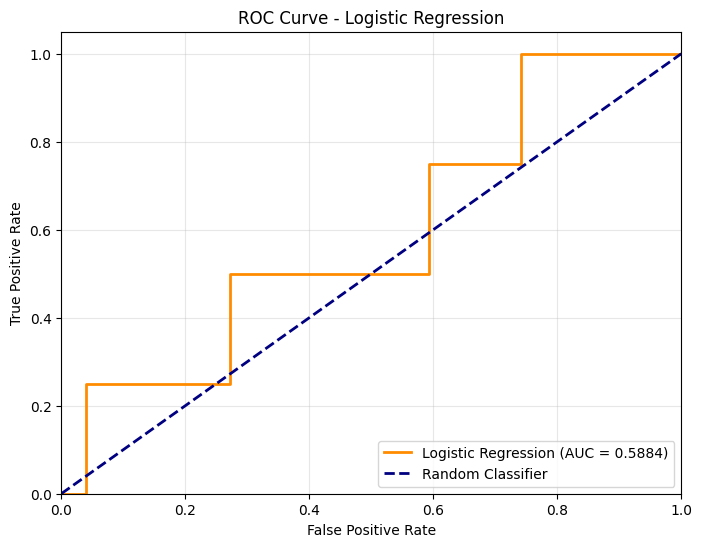


Top 10 Most Important Features (by absolute coefficient value):
            feature  coefficient  abs_coefficient
0        Year_Birth    -0.001903         0.001903
5          MntWines    -0.000054         0.000054
1            Income    -0.000018         0.000018
2           Kidhome     0.000000         0.000000
3          Teenhome     0.000000         0.000000
4           Recency     0.000000         0.000000
6         MntFruits     0.000000         0.000000
7   MntMeatProducts     0.000000         0.000000
8   MntFishProducts     0.000000         0.000000
9  MntSweetProducts     0.000000         0.000000


In [14]:
# ROC Curve for Logistic Regression
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance (coefficients) - for logistic regression
# Get the feature names after preprocessing
feature_names = (numerical_features + 
                list(best_lr_model.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_features)))

# Get coefficients
coefficients = best_lr_model.named_steps['classifier'].coef_[0]

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\nTop 10 Most Important Features (by absolute coefficient value):")
print(feature_importance_df.head(10))


## Combined ROC Curves for All Models

This section generates combined ROC curve plots for all 6 models (LR, DT, SVM, k-NN, RF, GB) across different sampling strategies (none, undersampling, SMOTE, ROS).


In [1]:
import os
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Import utility functions from models
import sys
sys.path.insert(0, os.path.join(os.getcwd(), 'models'))
from utils import load_dataframe, split_features, build_preprocessor, build_pipeline

print("Libraries imported successfully")


Libraries imported successfully


In [2]:
# Load data
df = load_dataframe()
X, y, num_cols, cat_cols = split_features(df)

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Numeric columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")


Dataset loaded: 2240 samples, 32 features
Target distribution:
Complain
0    2219
1      21
Name: count, dtype: int64
Numeric columns: 30
Categorical columns: 2


In [3]:
def get_model_with_params(model_name, best_params):
    """Create a model instance with the best parameters from grid search."""
    if model_name == 'lr':
        clf = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
        clf.set_params(**{k.replace('clf__', ''): v for k, v in best_params.items()})
        return clf, True  # needs scaling
    
    elif model_name == 'dt':
        clf = DecisionTreeClassifier(random_state=42, max_features='log2', ccp_alpha=0.0)
        clf.set_params(**{k.replace('clf__', ''): v for k, v in best_params.items()})
        return clf, False  # no scaling needed
    
    elif model_name == 'svm':
        clf = SVC(probability=True)
        clf.set_params(**{k.replace('clf__', ''): v for k, v in best_params.items()})
        return clf, True  # needs scaling
    
    elif model_name == 'knn':
        clf = KNeighborsClassifier()
        clf.set_params(**{k.replace('clf__', ''): v for k, v in best_params.items()})
        return clf, True  # needs scaling
    
    elif model_name == 'rf':
        clf = RandomForestClassifier(class_weight='balanced', n_estimators=400, random_state=42, n_jobs=-1)
        clf.set_params(**{k.replace('clf__', ''): v for k, v in best_params.items()})
        return clf, False  # no scaling needed
    
    elif model_name == 'gb':
        clf = GradientBoostingClassifier(random_state=42)
        clf.set_params(**{k.replace('clf__', ''): v for k, v in best_params.items()})
        return clf, False  # no scaling needed
    
    else:
        raise ValueError(f"Unknown model: {model_name}")

print("Model builder function defined")


Model builder function defined


In [4]:
def compute_roc_data(model_name, sampling='none'):
    """Load best params and compute ROC curve data for a model."""
    # Load best parameters
    param_file = f'models/outputs/{model_name}/{sampling}/best_params.json'
    
    if not os.path.exists(param_file):
        print(f"Warning: {param_file} not found, skipping...")
        return None, None, None
    
    with open(param_file, 'r') as f:
        best_params = json.load(f)
    
    # Create model with best parameters
    clf, needs_scaling = get_model_with_params(model_name, best_params)
    
    # Build preprocessing pipeline
    preprocessor = build_preprocessor(num_cols, cat_cols, scale_numeric=needs_scaling)
    
    # Build full pipeline with sampling
    estimator = build_pipeline(preprocessor, clf, sampling=sampling)
    
    # Get out-of-fold predictions using cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    probas = cross_val_predict(estimator, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y, probas)
    auc = roc_auc_score(y, probas)
    
    return fpr, tpr, auc

print("ROC computation function defined")


ROC computation function defined


In [ ]:
# Define model names and labels
models = {
    'lr': 'Logistic Regression',
    'dt': 'Decision Tree',
    'svm': 'SVM',
    'knn': 'k-NN',
    'rf': 'Random Forest',
    'gb': 'Gradient Boosting'
}

# Define sampling strategies
samplings = {
    'none': 'No Sampling (Baseline)',
    'under': 'Random Undersampling',
    'smote': 'SMOTE'
}

# Color palette for models
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628']

print("Configuration defined")


Configuration defined



Processing No Sampling (Baseline)...
  Logistic Regression: AUC=0.517
  Decision Tree: AUC=0.618
  SVM: AUC=0.406
  k-NN: AUC=0.539
  Random Forest: AUC=0.534
  Gradient Boosting: AUC=0.522

Processing Random Undersampling...
  Logistic Regression: AUC=0.574
  Decision Tree: AUC=0.577
  SVM: AUC=0.519
  k-NN: AUC=0.605
  Random Forest: AUC=0.558
  Gradient Boosting: AUC=0.534

Processing SMOTE...
  Logistic Regression: AUC=0.517
  Decision Tree: AUC=0.552
  SVM: AUC=0.551
  k-NN: AUC=0.492
  Random Forest: AUC=0.530
  Gradient Boosting: AUC=0.494

Processing Random Oversampling...


ValueError: Unknown sampling: ros

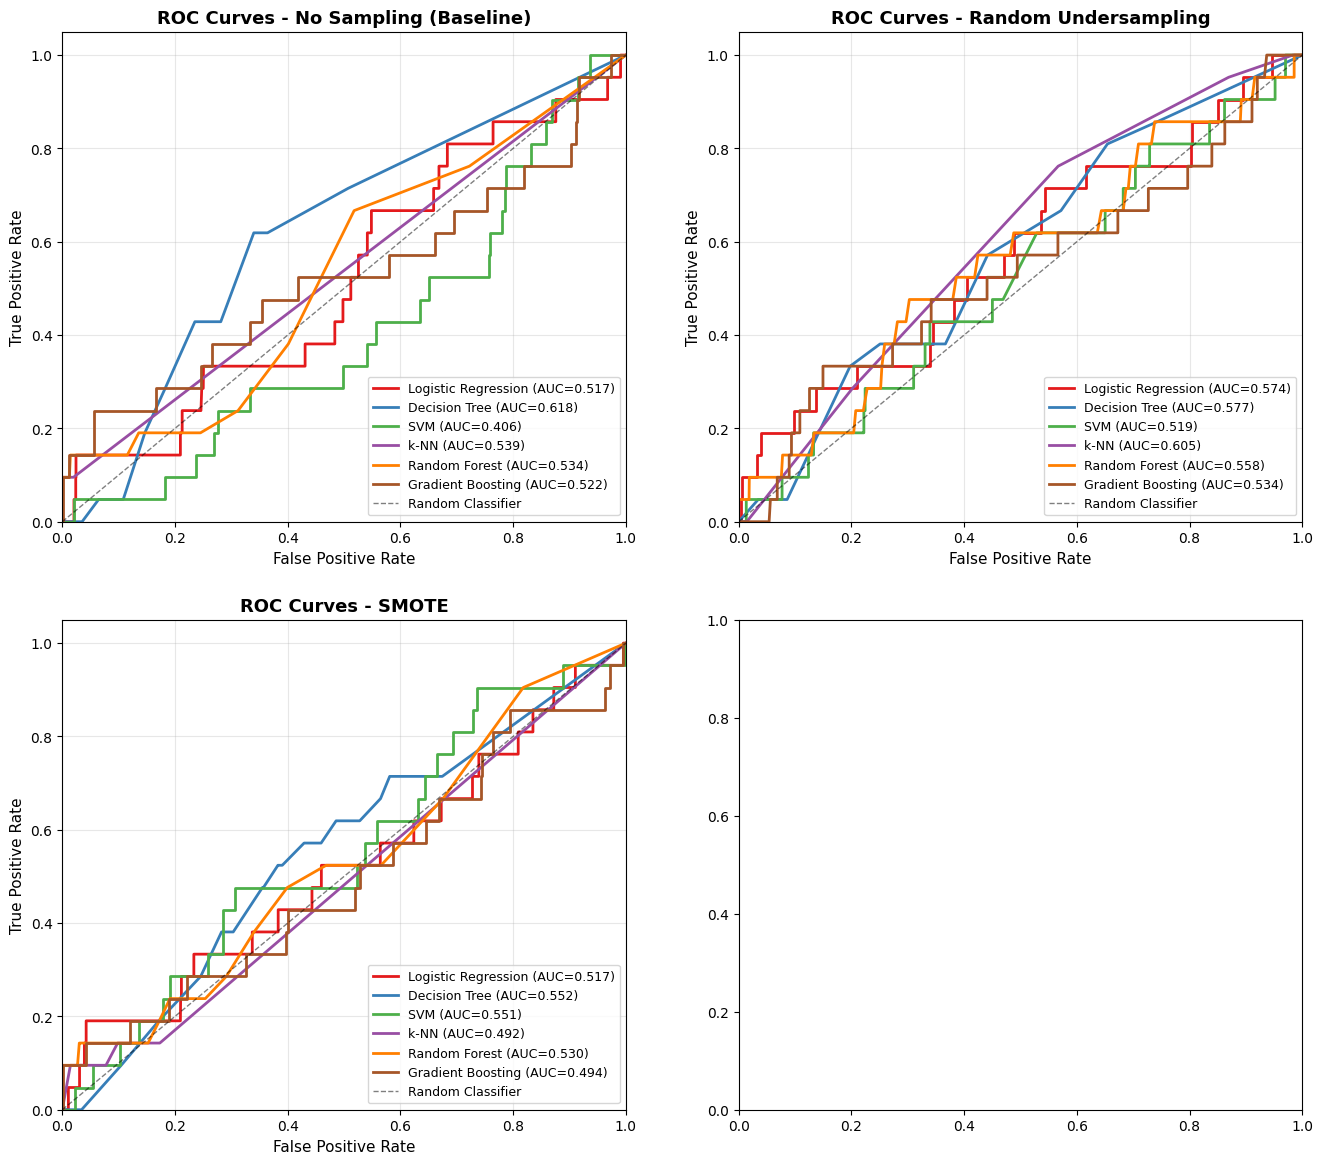

In [8]:
# Generate combined ROC curves for each sampling strategy
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (sampling_key, sampling_label) in enumerate(samplings.items()):
    ax = axes[idx]
    
    print(f"\nProcessing {sampling_label}...")
    
    for model_idx, (model_key, model_label) in enumerate(models.items()):
        fpr, tpr, auc = compute_roc_data(model_key, sampling=sampling_key)
        
        if fpr is not None:
            ax.plot(fpr, tpr, color=colors[model_idx], lw=2, 
                   label=f'{model_label} (AUC={auc:.3f})')
            print(f"  {model_label}: AUC={auc:.3f}")
    
    # Plot diagonal reference line
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Random Classifier')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'ROC Curves - {sampling_label}', fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nROC curves generated and saved as 'roc_curves_all_models.png'")


### Individual ROC Curve Plots by Sampling Strategy

Below are individual plots for each sampling strategy, which can be used separately in the report.



Generating individual plot for No Sampling (Baseline)...


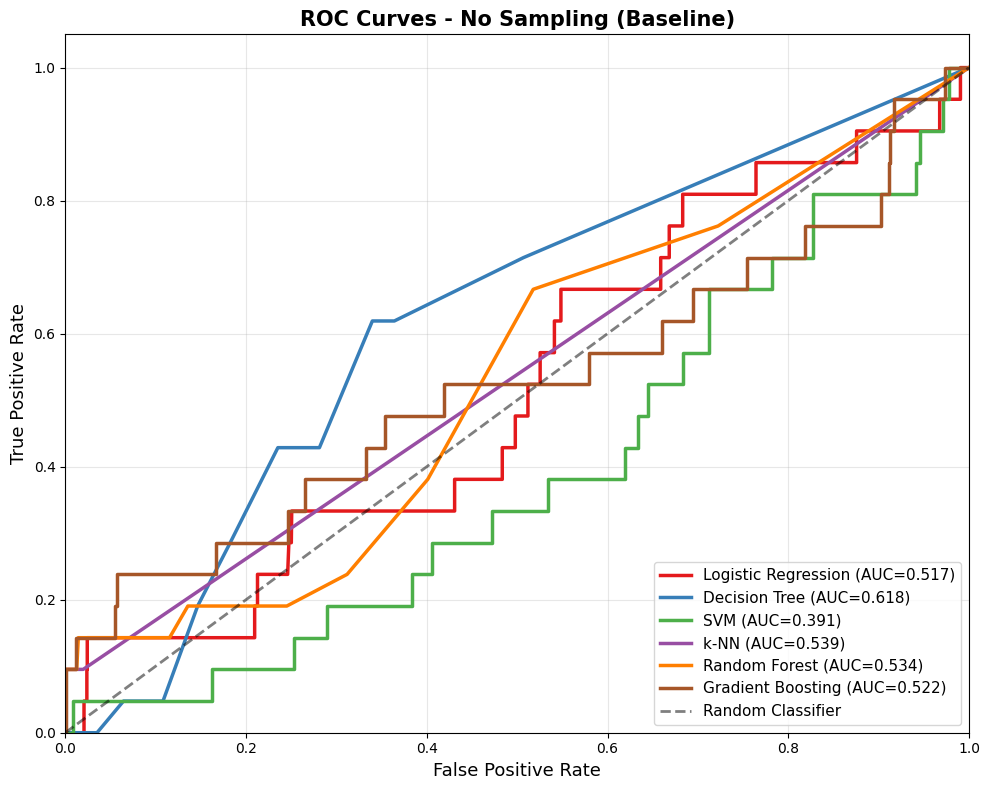

Saved as 'roc_curves_none.png'

Generating individual plot for Random Undersampling...


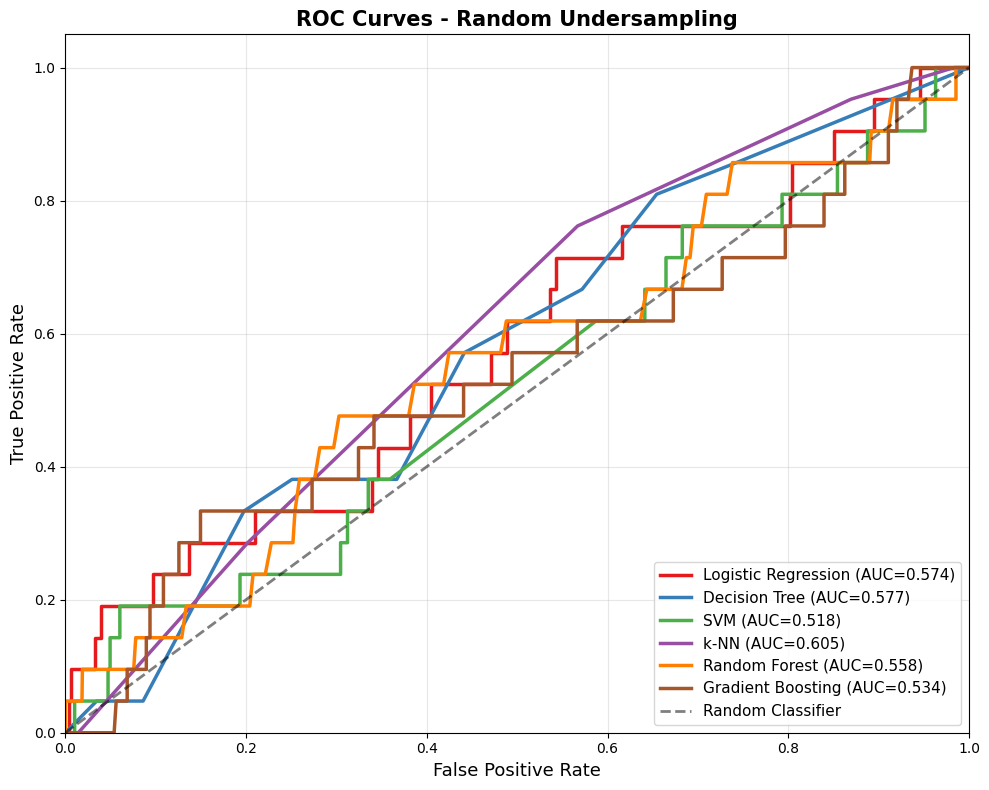

Saved as 'roc_curves_under.png'

Generating individual plot for SMOTE...


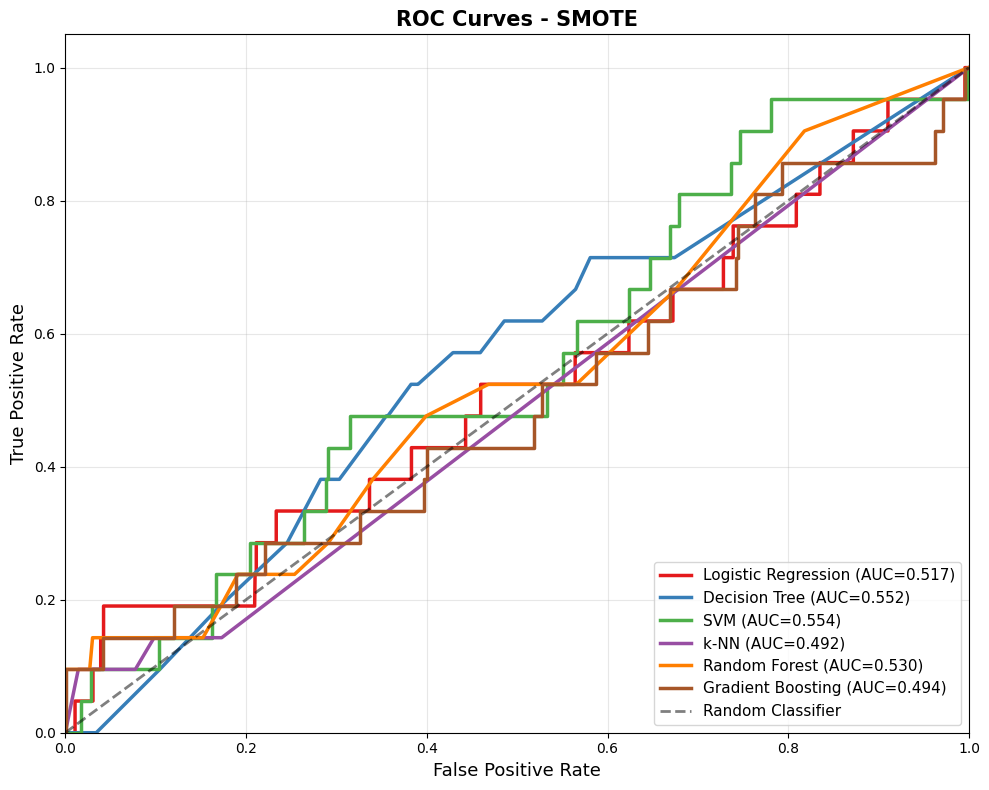

Saved as 'roc_curves_smote.png'

Generating individual plot for Random Oversampling...


ValueError: Unknown sampling: ros

<Figure size 1000x800 with 0 Axes>

In [7]:
# Generate individual ROC curve plots for each sampling strategy
for sampling_key, sampling_label in samplings.items():
    plt.figure(figsize=(10, 8))
    
    print(f"\nGenerating individual plot for {sampling_label}...")
    
    for model_idx, (model_key, model_label) in enumerate(models.items()):
        fpr, tpr, auc = compute_roc_data(model_key, sampling=sampling_key)
        
        if fpr is not None:
            plt.plot(fpr, tpr, color=colors[model_idx], lw=2.5, 
                    label=f'{model_label} (AUC={auc:.3f})')
    
    # Plot diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title(f'ROC Curves - {sampling_label}', fontsize=15, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save individual plot
    filename = f'roc_curves_{sampling_key}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Saved as '{filename}'")

print("\nAll ROC curve plots generated successfully!")


### Summary Metrics Table

The following table summarizes the performance metrics (precision, recall, ROC-AUC) for all models across different sampling strategies.


In [ ]:
# Load and display summary metrics
summary_df = pd.read_csv('models/outputs/summary.csv')

# Format for better readability
summary_df_formatted = summary_df.copy()
summary_df_formatted['precision'] = summary_df_formatted['precision'].apply(lambda x: f'{x:.4f}')
summary_df_formatted['recall'] = summary_df_formatted['recall'].apply(lambda x: f'{x:.4f}')
summary_df_formatted['roc_auc'] = summary_df_formatted['roc_auc'].apply(lambda x: f'{x:.4f}')

# Create a pivot table for better visualization
pivot_table = summary_df.pivot(index='model', columns='sampling', values=['precision', 'recall', 'roc_auc'])

print("Summary Metrics for All Models and Sampling Strategies:")
print("="*80)
display(summary_df_formatted)

print("\n\nPivot View - Precision:")
print("="*80)
display(pivot_table['precision'].round(4))

print("\n\nPivot View - Recall:")
print("="*80)
display(pivot_table['recall'].round(4))

print("\n\nPivot View - ROC-AUC:")
print("="*80)
display(pivot_table['roc_auc'].round(4))


### Confusion Matrices

Below are the confusion matrices for all models. Each shows the true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP).


In [9]:
# Display confusion matrices for all models
for sampling_key, sampling_label in samplings.items():
    print(f"\n{'='*80}")
    print(f"Confusion Matrices - {sampling_label}")
    print(f"{'='*80}\n")
    
    for model_key, model_label in models.items():
        metrics_file = f'models/outputs/{model_key}/{sampling_key}/metrics.json'
        
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                metrics = json.load(f)
            
            cm = np.array(metrics['confusion_matrix'])
            tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
            
            print(f"{model_label}:")
            print(f"  [[TN={tn:4d}  FP={fp:4d}]")
            print(f"   [FN={fn:4d}  TP={tp:4d}]]")
            print(f"  Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, ROC-AUC: {metrics['roc_auc']:.4f}")
            print()

print("\nNote: TN=True Negative, FP=False Positive, FN=False Negative, TP=True Positive")



Confusion Matrices - No Sampling (Baseline)



NameError: name 'np' is not defined